In [1]:
%pylab inline

import math

Populating the interactive namespace from numpy and matplotlib


# Visual Composition

### Scores

In [2]:
# entropy of a given list of probabilities
def H(prob):
    if not 0.99999 <= np.sum(prob) <= 1.0001:
        prob = normalize(prob)
    
    _s = 0
    for i in prob:
        if(i > 0):
            _s -= i*math.log2(i)
    return _s

In [3]:
# returns visual information
#  internal VI := probabilities are selected from the same row 
#  external VI := probabilities are selected from the same column 
def VI(prob, c = None):
    if c == None:
        c = max_H(len(prob))
    return c - H(normalize(prob))

### Utilities

In [4]:
# returns the "max entropy" for a list of "n" elements
def max_H(n):
    return math.log2(n)

In [5]:
# normalizes "prob"
def normalize(prob):
    return prob / np.sum(prob)

In [6]:
# flattens a grouped probability list
def flat(arr):
    return [i for tup in arr for i in tup]

In [68]:
# maps a number from given range to given range
def map(value, start1, stop1, start2, stop2):
    return start2 + (stop2 - start2) * ((value - start1) / (stop1 - start1))

### Calculate all scores

In [7]:
# calculates "VI_int" and "VI_ext" scores from visual entity matrix "O"
# gene = gene index                        (row)
# param = [ group_index, param_index ]     (column)
def calculate_VIs(O, gene, param):
    # pick a constant for "O"
    c = max_H(max(len(O), len(flat(O[gene,:]))))
    
    VI_int = VI(normalize( flat(O[gene,:]) ), c)
    VI_ext = VI(normalize( [i[param[1]] for i in O[:,param[0]]] ), c)
    return VI_int, VI_ext

In [8]:
def calculate_pareto(vi_i_p, vi_e_p, vi_i, vi_e):
    c_i = vi_i - vi_i_p
    c_e = vi_e - vi_e_p
    
    if c_i < 0 or c_e < 0:
        return -1
    elif c_i > 0 or c_e > 0:
        return 1
    else:
        return 0

### Mutation method

In [9]:
# mutates the given visual entity matrix "0"
def mutate(O, ran):
    def _mut(mat, gene_index=None, index=None, value=None):
        # copy the matrix
        _O = mat.copy()

        ## choose a gene strip randomly
        if gene_index is None:
            gene_index = random.randint(0, len(_O))
        gene = _O[gene_index]

        ## choose a parameter in gene strip randomly
        if index is None:
            group_index = random.randint(0, len(gene))
            index = ( group_index, random.randint(0, len(gene[group_index])) )

        ## calculate prior VI scores
        VI_i_p, VI_e_p = calculate_VIs(_O, gene_index, index)

        ## choose a mutation value randomly
        if value is None:
            value = random.random()*ran#*gene[index[0]][index[1]]

        ## choose an operation randomly (add(1), substract(-1), no_change(0))
        operation = random.choice([-1,0,1])

        ## choose one neighbor randomly and adjust its value (left(-1), right(1))
        neighbor = random.randint(0, len(gene[index[0]]))
        while neighbor == index[1]:
            neighbor = random.randint(0, len(gene[index[0]]))

        ## apply mutation to the gene
        gene[index[0]][index[1]] += operation*value
        gene[index[0]][neighbor] += -operation*value

        ## calculate VI scores
        VI_i, VI_e = calculate_VIs(_O, gene_index, index)

        ## calculate decisions
        pareto = calculate_pareto(VI_i_p, VI_e_p, VI_i, VI_e)
        
        # -1 -> pick different gene
        #  0 -> pick different mutation value
        #  1 -> accept mutation
        if pareto == -1:
            return _mut(mat)
        elif pareto == 0:
            return _mut(mat, gene_index=gene_index, index=index)
        elif pareto == 1:
            return _O
        
    try:
        return _mut(O)
    except RecursionError as re:
        print(".", end='')
        return O

### Run evolution

In [10]:
## evolve 'O' for 'n' iterations
def evolve(O, size, n=50, range=1):
    _O = O.copy()

    # run n iterations
    for _ in np.arange(n):
        # mutates the matrix
        _O = mutate(_O, range)
    
    # balance negatives
    for gene in _O:
        for i, gene_strip in enumerate(gene):
            sum = size[i]
            gene_strip = [abs(i) for i in gene_strip]
            gene[i] = [i*sum/np.sum(gene_strip) for i in gene_strip]
            
    # returns evolved matrix
    return _O

### Show 2D

In [11]:
# displays compositions as image
def show_comp(O, size=(400,400), legend=False, grids=False):
    im = np.ones(size[:2])
    
    ## rectangles
    for rect_xy in O:
        r_x = rect_xy[0]
        r_y = rect_xy[1]
        
        sub_im = im[int(r_y[0]):int(r_y[0]+r_y[1]),
                    int(r_x[0]):int(r_x[0]+r_x[1])]
        im[int(r_y[0]):int(r_y[0]+r_y[1]),
           int(r_x[0]):int(r_x[0]+r_x[1])] = np.logical_xor(sub_im, 1).astype(int)
    
    
    ## calculate subgrids
    coords = np.zeros([shape(O[0])[0], 1]).tolist()
    for gene in O:
        for i, gene_strip in enumerate(gene):
            coords[i].extend([gene_strip[0],gene_strip[0]+gene_strip[1]])
    for i in arange(len(coords)):
        coords[i].sort()
        
    ## determine which rectangles are black
    blacks = [False]*(len(coords[0])*len(coords[1]))
    for i in arange(len(blacks)):
        y = i//len(coords[0])
        x = i%len(coords[0])
        
        _x1 = coords[0][x]
        _x2 = coords[0][x+1] if len(coords[0]) > x+1 else size[0]
            
        _y1 = coords[1][y]
        _y2 = coords[1][y+1] if len(coords[1]) > y+1 else size[1]
        
        if im[int((_y1+_y2)*0.5), int((_x1+_x2)*0.5)] == 0:
            blacks[i] = True
    
    
    ## grid lines
    if grids:
        for rect_xy in O:
            r_x = rect_xy[0]
            r_y = rect_xy[1]
        
            # columns
            im[:,int(r_x[0])] = 0
            im[:,int(r_x[0]+r_x[1])] = 0
            # rows
            im[int(r_y[0]),:] = 0
            im[int(r_y[0]+r_y[1]),:] = 0
    
    imshow(im, cmap='gray')
    if legend is True:
        colorbar()
    
    return coords, blacks

### Show 3D

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [13]:
def create_voxel(O, size=(30,30,30)):
    # create voxels
    voxels = np.zeros(size[:3])
    
    # blocks
    for rect_xyz in O:
        r_x = rect_xyz[0]
        r_y = rect_xyz[1]
        r_z = rect_xyz[2]
        
        sub_v = voxels[int(r_z[0]):int(r_z[0]+r_z[1]),
                       int(r_y[0]):int(r_y[0]+r_y[1]),
                       int(r_x[0]):int(r_x[0]+r_x[1])]
        voxels[int(r_z[0]):int(r_z[0]+r_z[1]),
               int(r_y[0]):int(r_y[0]+r_y[1]),
               int(r_x[0]):int(r_x[0]+r_x[1])] = np.logical_xor(sub_v, 1).astype(int)
        
    return voxels

In [14]:
# show one composition
def show_voxel(O, size=(30,30,30)):
    fig = plt.figure(figsize=(5,4))
    ax = fig.gca(projection='3d')
    ax.voxels(create_voxel(O, size=size))
    plt.show()

### Create Matrices

In [15]:
# total size of the image
SIZE = (300, 300)

# 5 compositions (2D) [(x1,x2-x1,x3-x2-x1), (y1,y2-y1,y3-y2-y1)]
O = np.array([[(100,100,100), (100,100,100)], # (100,100,100)], # for 3D 
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)]])

In [16]:
# create 'n' compositions with 9 grid cells
def create_compositions(n, ndim=2, size=(300,300)):
    return np.ones((n, ndim, 3))*(size[0]//3)

## Testing

#### 2D compositions
Creates and runs evolutions for 2D compositions. `grids=True` argument on `show_comp` draws the gridlines.

In [17]:
SIZE = (200,200)
O = create_compositions(5)

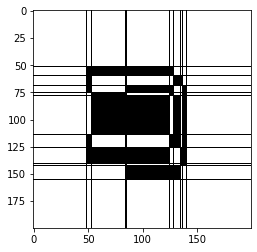

In [18]:
_O = evolve(O, SIZE, n=100, range=5.0)
show_comp(_O, size=SIZE, grids=True);

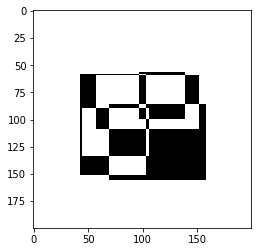

In [19]:
_O = evolve(O, SIZE,  n=1000, range=1.0)
show_comp(_O, size=SIZE, grids=False);

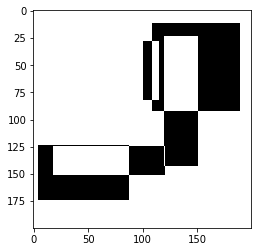

In [20]:
_O = evolve(O, SIZE,  n=2000, range=1.0)
show_comp(_O, size=SIZE);

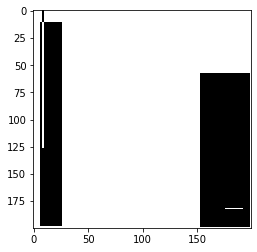

In [21]:
_O = evolve(O, SIZE, n=5000, range=1.0)
show_comp(_O, size=SIZE, grids=False);

#### 3D Compositions
Creates and runs evolutions for 3D compositions. Size shouldn't be too big. 

In [22]:
SIZE = (30,30,30)
O_3D = create_compositions(20, 3, SIZE)

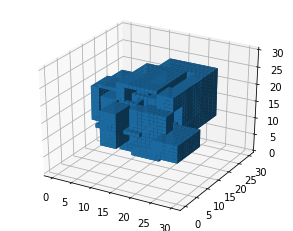

In [23]:
_O_3D = evolve(O_3D, SIZE, n=100, range=5.5)
show_voxel(_O_3D, size=SIZE)

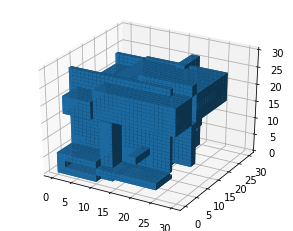

In [24]:
_O_3D = evolve(O_3D, SIZE, n=1000, range=1.5)
show_voxel(_O_3D, size=SIZE)

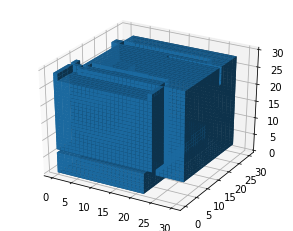

In [25]:
_O_3D = evolve(O_3D, SIZE, n=2000, range=1.0)
show_voxel(_O_3D, size=SIZE)

# Cropping images with visual composition data

Read image data

In [19]:
im = imread("im/goleta_osm.jpg")
im_extend = [[34.44, -119.9], [34.4, -119.83]]

In [20]:
shape(im)

(565, 815, 3)

Evolve a composition

In [21]:
# SIZE = (shape(im)[0], shape(im)[1])
SIZE = (200, 200)
O = create_compositions(5)

In [26]:
_O = evolve(O, SIZE, n=200, range=8.0)

121


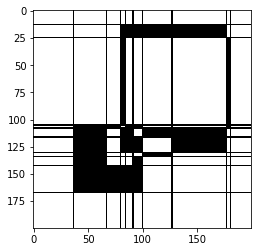

In [27]:
coords, blacks = show_comp(_O, size=SIZE, grids=True)
print(len(blacks))

This function uses only the central rectangles that make up the composition.

In [58]:
def chop_image_rects(O, size):
    x_dim = shape(im)[1]
    y_dim = shape(im)[0]
    
    x_scale = x_dim/size[1]
    y_scale = y_dim/size[0]
    
    parts = []
    extents = []
    for genes in O:
        _x1 = genes[0][0]
        _x2 = genes[0][0]+genes[0][1]
        
        _y1 = genes[1][0]
        _y2 = genes[1][0]+genes[1][1]
        
        _x1 *= x_scale
        _x2 *= x_scale
        _y1 *= y_scale
        _y2 *= y_scale
        
        if int(_y2)-int(_y1) < 1:
            _y2 += 1
        if int(_x2)-int(_x1) < 1:
            _x2 += 1
        parts.append(im[int(_y1):int(_y2), int(_x1):int(_x2)])
        
        # top-left extent
        p1 = im_extend[0]
        # bottom-right extent
        p2 = im_extend[1]
        extents.append([[map(_y1, 0, y_dim, p1[0], p2[0]), map(_x1, 0, x_dim, p1[1], p2[1])],
                        [map(_y2, 0, y_dim, p1[0], p2[0]), map(_x2, 0, x_dim, p1[1], p2[1])]])
        
        
    return parts, extents

In [81]:
def show_chopped_images(parts, axis=False):
    f = plt.figure(figsize=(20,15))
    for i in range(len(parts)):
#         try:
        sq = int(sqrt(len(parts)))
        f.add_subplot(sq, ceil(len(parts)/sq), i+1)
        plt.imshow(parts[i])
        plt.axis('off' if not axis else 'on')
#         except:
#             pass

    plt.show()

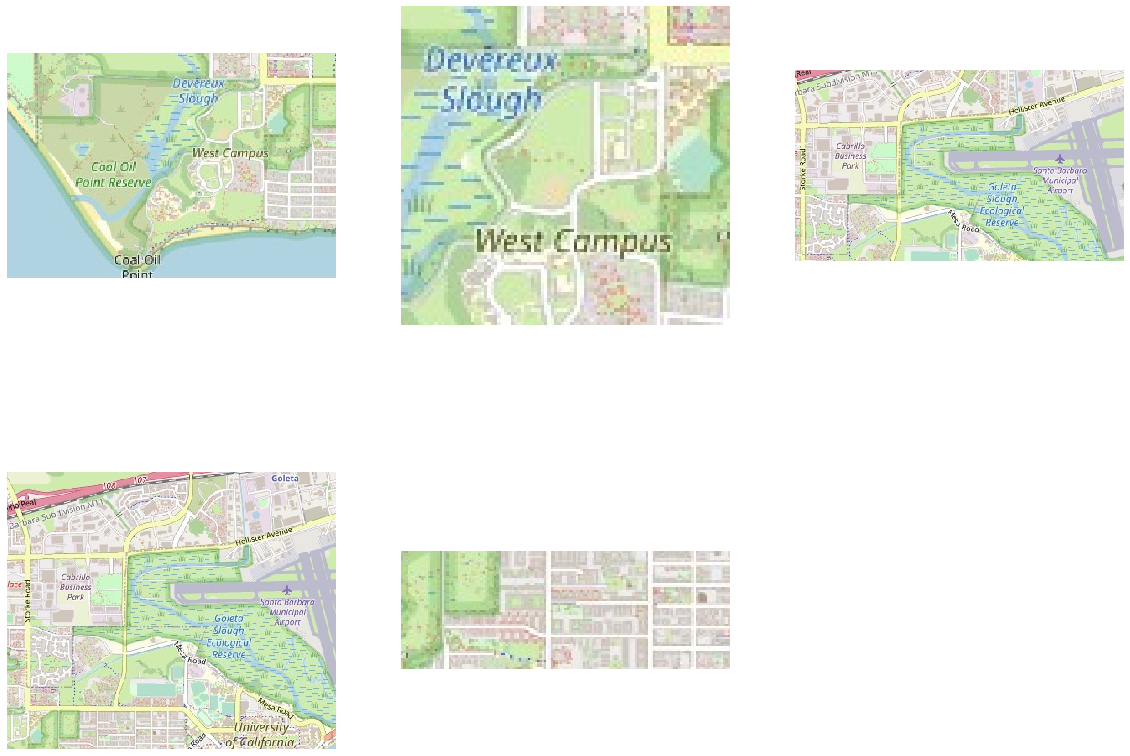

In [82]:
parts, extents = chop_image_rects(_O, SIZE)
show_chopped_images(parts)

This function uses all the grid cells available in the final composition.

In [90]:
from skimage import filters

def chop_image():
    x_dim = shape(im)[1]
    y_dim = shape(im)[0]
    
    x_scale = x_dim/SIZE[1]
    y_scale = y_dim/SIZE[0]
    
    parts = []
    extents = []
    for i in arange(len(blacks)):
        y = i//len(coords[0])
        x = i%len(coords[0])

        _x1 = coords[0][x]
        _x2 = coords[0][x+1] if len(coords[0]) > x+1 else SIZE[0]

        _y1 = coords[1][y]
        _y2 = coords[1][y+1] if len(coords[1]) > y+1 else SIZE[1]

        _x1 *= x_scale
        _x2 *= x_scale
        _y1 *= y_scale
        _y2 *= y_scale

        if int(_y2)-int(_y1) < 1:
            _y2 += 1
        if int(_x2)-int(_x1) < 1:
            _x2 += 1
        parts.append(im[int(_y1):int(_y2), int(_x1):int(_x2)])
        if blacks[i]:
            parts[i] = filters.sobel(parts[i]) ## change to something else
            
            
        # top-left extent
        p1 = im_extend[0]
        # bottom-right extent
        p2 = im_extend[1]
        extents.append([[map(_y1, 0, y_dim, p1[0], p2[0]), map(_x1, 0, x_dim, p1[1], p2[1])],
                        [map(_y2, 0, y_dim, p1[0], p2[0]), map(_x2, 0, x_dim, p1[1], p2[1])]])
            
    return parts, extents

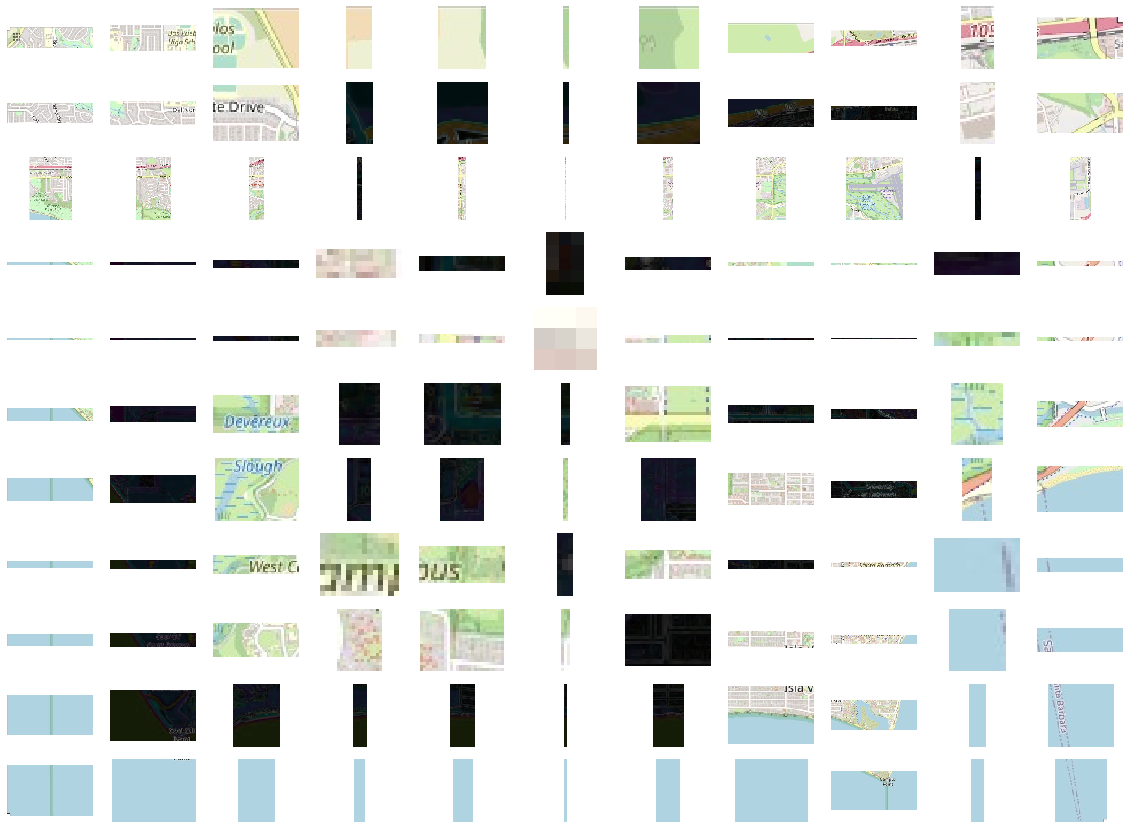

In [92]:
parts, extents = chop_image()
show_chopped_images(parts)

In [34]:
SIZE = (200, 200)
O = create_compositions(5)

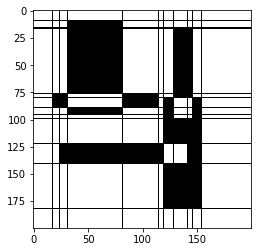

In [35]:
_O = evolve(O, SIZE, n=1000, range=2.0)
coords, blacks = show_comp(_O, size=SIZE, grids=True)

In [93]:
parts, extents = chop_image()

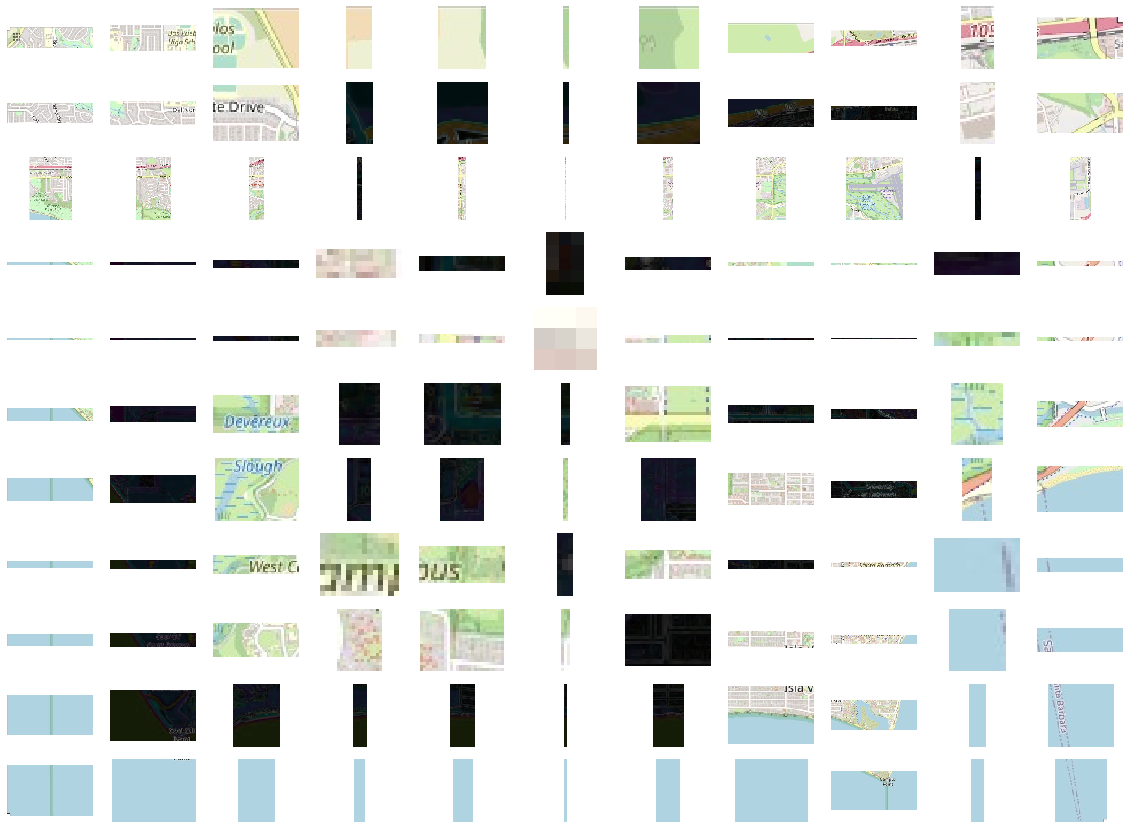

In [94]:
show_chopped_images(chopped_im, axis=False)

# Entropy-Complexity Plane

Running entropy-complexity analysis on the chopped up images. 

Possible problematic part is that the number of permutations (`(dx*dy)!`) must be strictly smaller than the number of pixels in the image. In this case, `(dx*dy)! = 24`, but some sub-images have smaller number of pixels.

In [95]:
import math        # factorial
import itertools   # permutations

In [96]:
def permutations(I, dx=2):
    _y = shape(I)[0]
    _x = shape(I)[1]
    _n = (_x-dx+1)*(_y-dx+1)
    
    _c = 0
    
    # all permuatations for ordinals
    counts = [ [0, list(i)] for i in list(itertools.permutations(arange(dx*dx)))]
    
    if _x*_y/len(counts) < 2:
        return None
    
    parts = zeros((_n, dx, dx))
    ordinals = zeros((_n, dx*dx))
    for i in arange(_y-dx+1):
        for j in arange(_x-dx+1):
            for k in arange(dx):
                for l in arange(dx):
                    parts[_c][k][l] = I[i+k][j+l]
            
            # calculate ordinals 
            flattened = list(enumerate([item for sublist in parts[_c] for item in sublist]))
            flattened.sort(key = lambda item: item[1])
            ordinals[_c] = [x[0] for x in flattened]
            
            # increment the count for corresponding ordinal pattern
            for p in counts:
                if (p[1] == ordinals[_c]).all():
                    p[0] += 1
                    break
            
            # inc index
            _c+=1
    
    freq = [c[0] for c in counts]
    p = [float(i)/sum(freq) for i in freq]
    
    return p#, parts, ordinals

### Permutational entropy
The value of `H` quantifies the degree of "disorder" in the occurance of the pixels of an image represented by the matrix `I`. `H ~~ 1` if the pixels appear in random order, and `H ~~ 0` if they always appear in the same order.

In [97]:
def H(p, norm=True):
    # safeguard for small images
    if p is None:
        return -1
    
    # maximal entropy
    max_s = np.log(size(p))
    
    # 
    s = 0
    for pi in p:
        if pi != 0:
            s += pi*np.log(1/pi)
           
    if norm: return 1/max_s*s
    else: return s

### Statistical Complexity
`C ~~ 0` when all permutations are "disordered" `P={p=1/n; i=1,...,n}` and  "ordered" `P={p=\delta_1,i; i=1,...,n}`. Otherwise `C > 0`.

In [98]:
def C(p):
    # safeguard for small images
    if p is None:
        return -1
    
    n = size(p)
    
    # uniform dist
    u = np.ones(n)*1/n
    
    # jensen-shannon divergence
    D_PU = H((p+u)*.5, norm=False) - H(p, norm=False)*0.5 - H(u, norm=False)*0.5
    
    # normalization constant
    D_PU_max = -0.5*((n+1)/n*np.log(n+1)+np.log(n)-2*np.log(2*n))
    
    return D_PU*H(p)/D_PU_max

### Run

In [108]:
## Calculates entropy and complexity values for each part of the image,
## stores them in a dict={'image': A, 'H': H(p), 'C': C(p)}
## and sorts the final array based on 'key'
def calculate_all(As, extents, key='H'):
    im_struct = []
    for i, A in enumerate(As):
        _A = np.dot(A, [0.33, 0.33, 0.33])
        p = permutations(_A)
        im_struct.append({'image': A, 'extent': extents[i], 'H': H(p), 'C': C(p)})
        
    im_struct = sorted(im_struct, key = lambda i: i[key], reverse=True)
    
    return im_struct

In [138]:
## display all image parts
def show_all(As, labels=True):
    f = plt.figure(figsize=(20,15))
    for i, A in enumerate(As):
        sq = int(sqrt(len(As)))
        ax = f.add_subplot(sq, ceil(len(As)/sq), i+1)
        if labels:
            plt.title("H={:.2f}, C={:.2f}".format(A['H'], A['C']))
        plt.imshow(A['image'])
        plt.axis('off')

    plt.show()

In [141]:
parts, extents = chop_image_rects(_O, SIZE)
objs = calculate_all(parts, extents)

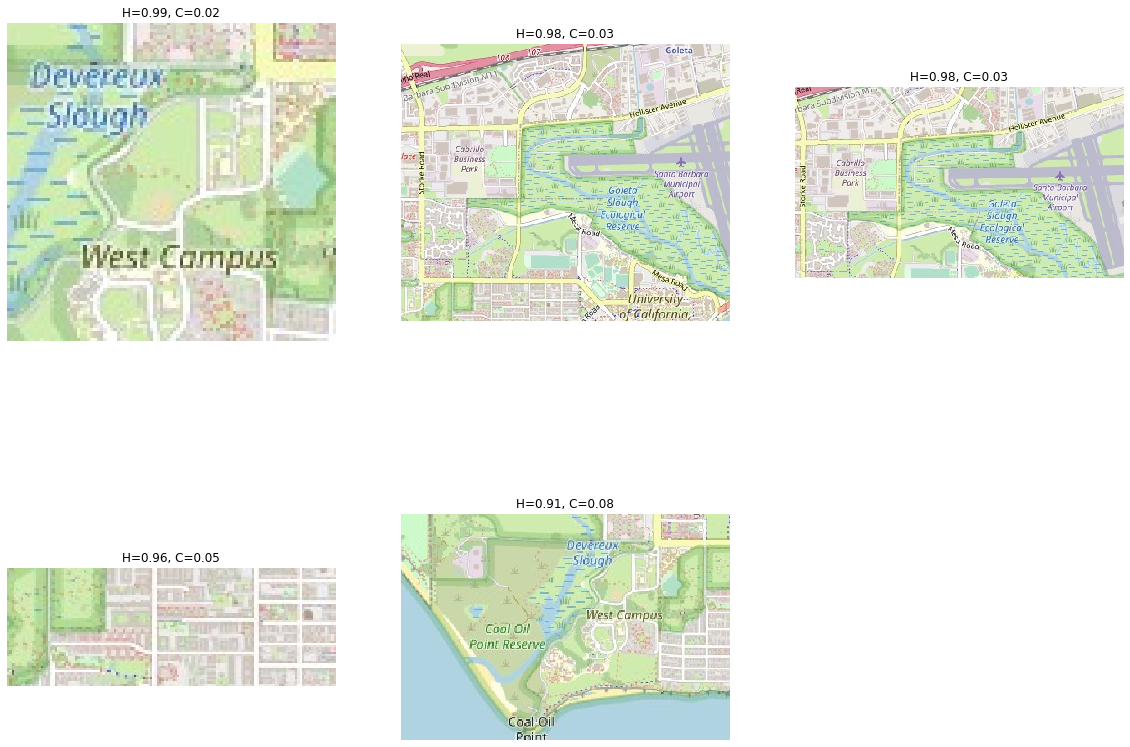

In [142]:
show_all(objs)

In [53]:
objs = calculate_all(chopped_im)

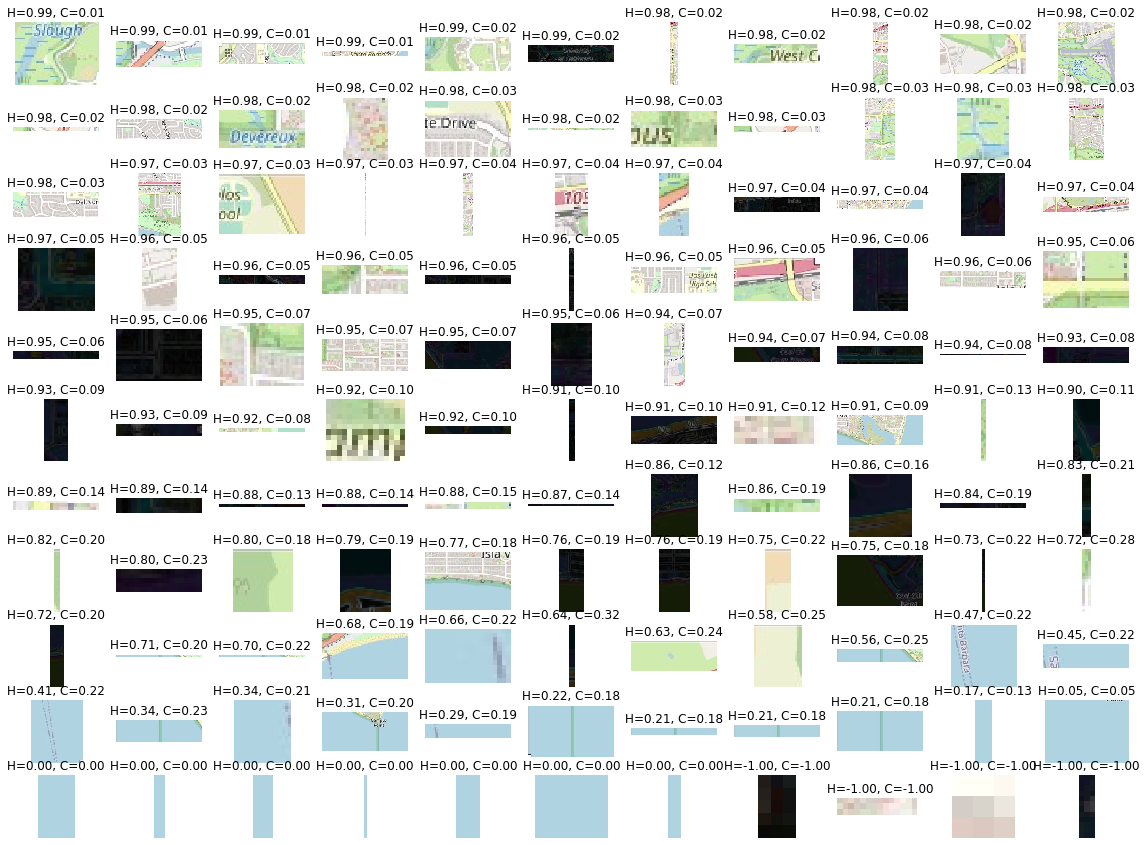

In [54]:
show_all(objs, labels=True)

In [143]:
parts, extents = chop_image()
objs = calculate_all(parts, extents, key='C')

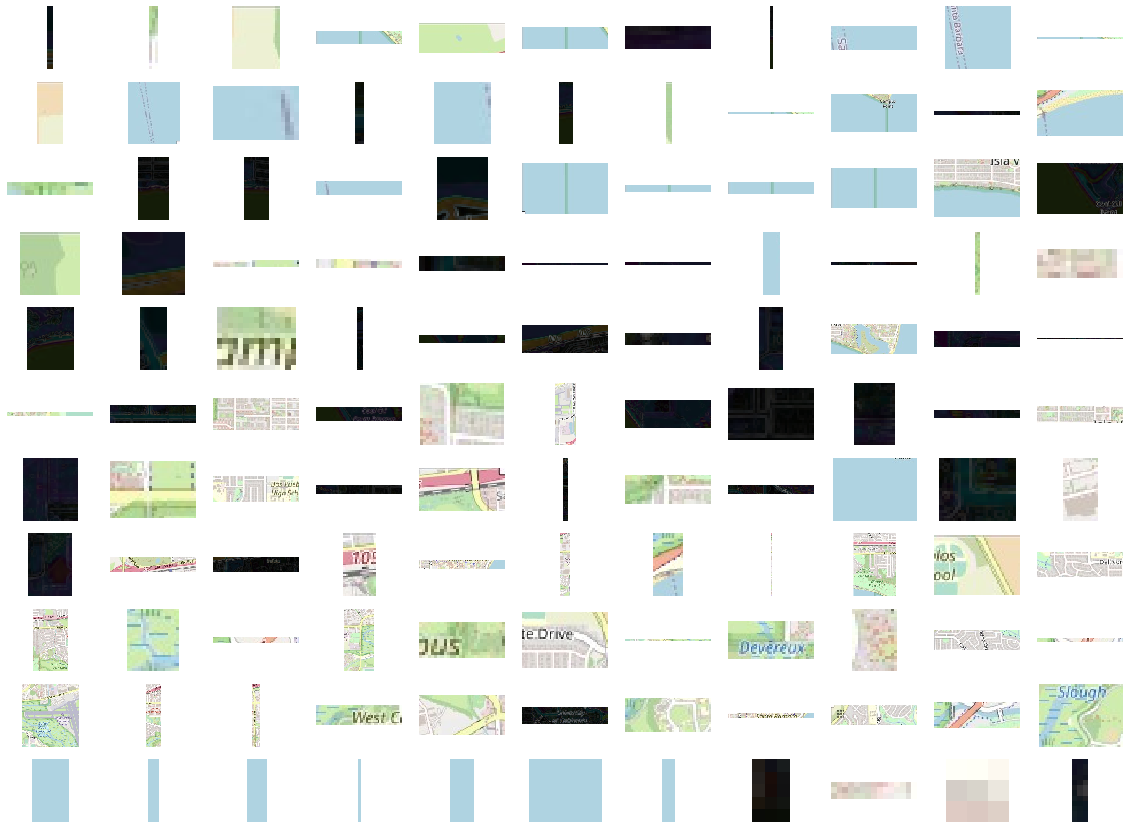

In [144]:
show_all(objs, labels=False)